In [1]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb, fit_glm_animal
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
dfs = [pd.read_csv('/root/capsule/code/data_management/session_assets.csv'),
        pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')]
df = pd.concat(dfs)
session_list = df['session_id'].values.tolist()
ani_list = [str(session).split('_')[1] for session in session_list if str(session).startswith('behavior')]
session_list = [session for session in session_list if str(session).startswith('behavior')]
ani_session_df = pd.DataFrame({'animal': ani_list, 'session_id': session_list})

In [3]:
ani_list = ani_session_df['animal'].unique().tolist()
model_name = 'stan_qLearning_5params'

In [7]:
session_tbl = makeSessionDF('behavior_716325_2024-05-31_10-31-14', model_name=model_name, cut_interruptions=True, load_glm=True)

ValueError: Must have equal len keys and value when setting with an iterable

In [31]:
p_choice_R = session_tbl['pChoice'].values.copy()
p_choice_R[session_tbl['choice'].values == 0] = 1 - p_choice_R[session_tbl['choice'].values == 0]
p_choice_R_glm = session_tbl['pChoice_glm'].values.copy()
p_choice_R_glm[session_tbl['choice'].values == 0] = 1 - p_choice_R_glm[session_tbl['choice'].values == 0]


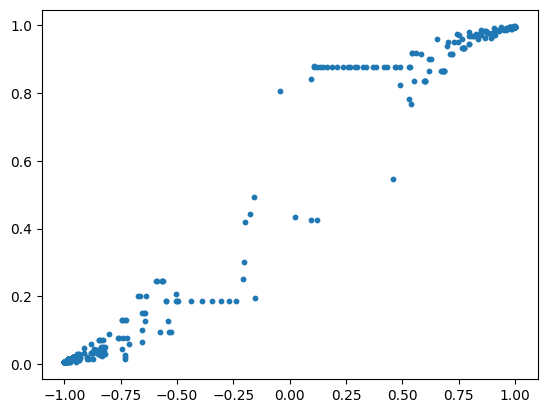

In [36]:
plt.scatter(session_tbl['Q_r'] - session_tbl['Q_l'], p_choice_R_glm, s = 10)

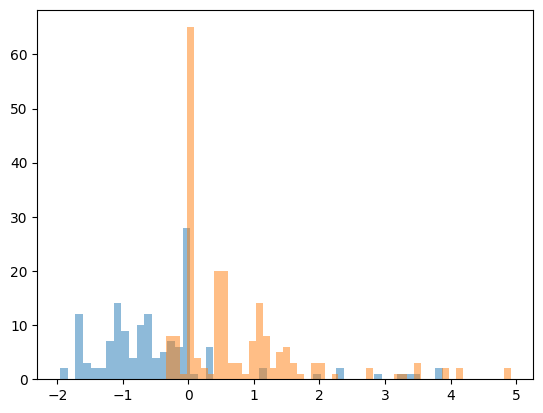

In [37]:
target = 'policy_glm_change_log_odd'
plt.hist(session_tbl[session_tbl['outcome'].values==0][target], bins = 50, alpha=0.5);
plt.hist(session_tbl[session_tbl['outcome'].values==1][target], bins = 50, alpha=0.5);

In [ ]:
plt.hist(session_tbl[session_tbl['outcome'].values==1]['policy_change'], bins = 20)

In [42]:
session_tbl['outcome_prev']==0

176     True
177     True
178     True
179    False
180    False
       ...  
524     True
525     True
526     True
527     True
528     True
Name: outcome_prev, Length: 353, dtype: bool

Optimization terminated successfully.
         Current function value: 0.208968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.208968
         Iterations 8


({'reward_side_and_choice_history_model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7fd1099252d0>,
  'reward_side_and_noreward_side_history_model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7fd109925d20>,
  'choice_prob_by_session': {'behavior_716325_2024-05-29_10-33-32': array([       nan,        nan,        nan,        nan,        nan,
          0.99162299, 0.99183919, 0.99183919, 0.99183919, 0.99183919,
          0.99183919, 0.97526574, 0.98592962, 0.98912007, 0.96701973,
          0.98555912, 0.98912007, 0.98905651, 0.99162299, 0.99183919,
          0.99183919, 0.99183919, 0.99183919, 0.99183919, 0.99183919,
          0.99183919, 0.99183919, 0.97526574, 0.98592962, 0.98912007,
          0.96701973, 0.95678738, 0.05554087, 0.5463334 , 0.76936765,
          0.26834797, 0.78338113, 0.92197065, 0.96749771, 0.98761438,
          0.03383161, 0.67948322, 0.19265168, 0.07031435, 0.54752221,
          0.76566612, 0.16231968, 0.31839855, 0.63275227, 

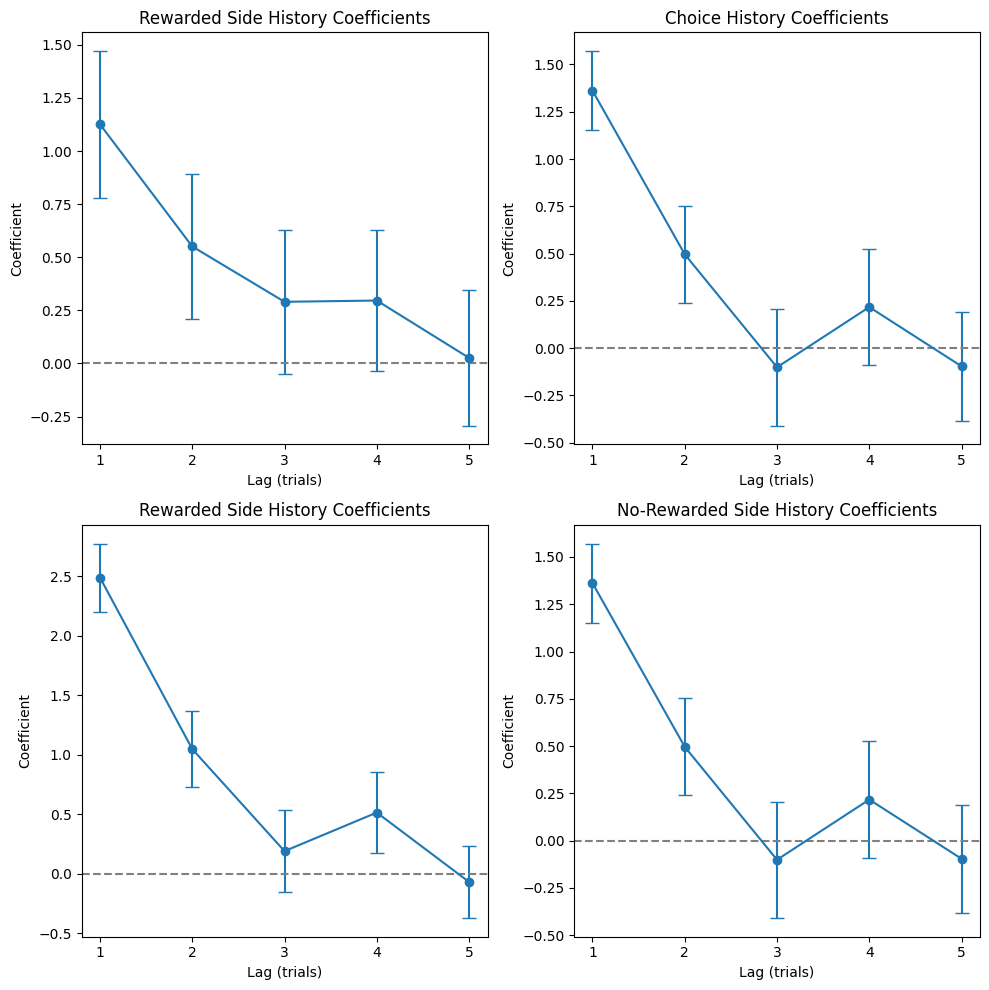

In [4]:
fit_glm_animal('716325', plot=True)

Processing animal 716325...
Optimization terminated successfully.
         Current function value: 0.208968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.208968
         Iterations 8
Processing animal 717121...
Optimization terminated successfully.
         Current function value: 0.127968
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.127968
         Iterations 9
Processing animal 717259...
Optimization terminated successfully.
         Current function value: 0.179944
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.179944
         Iterations 8
Processing animal 717263...
Optimization terminated successfully.
         Current function value: 0.145628
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.145628
         Iterations 9
Processing animal 714116...
Optimization terminated successfully.
      

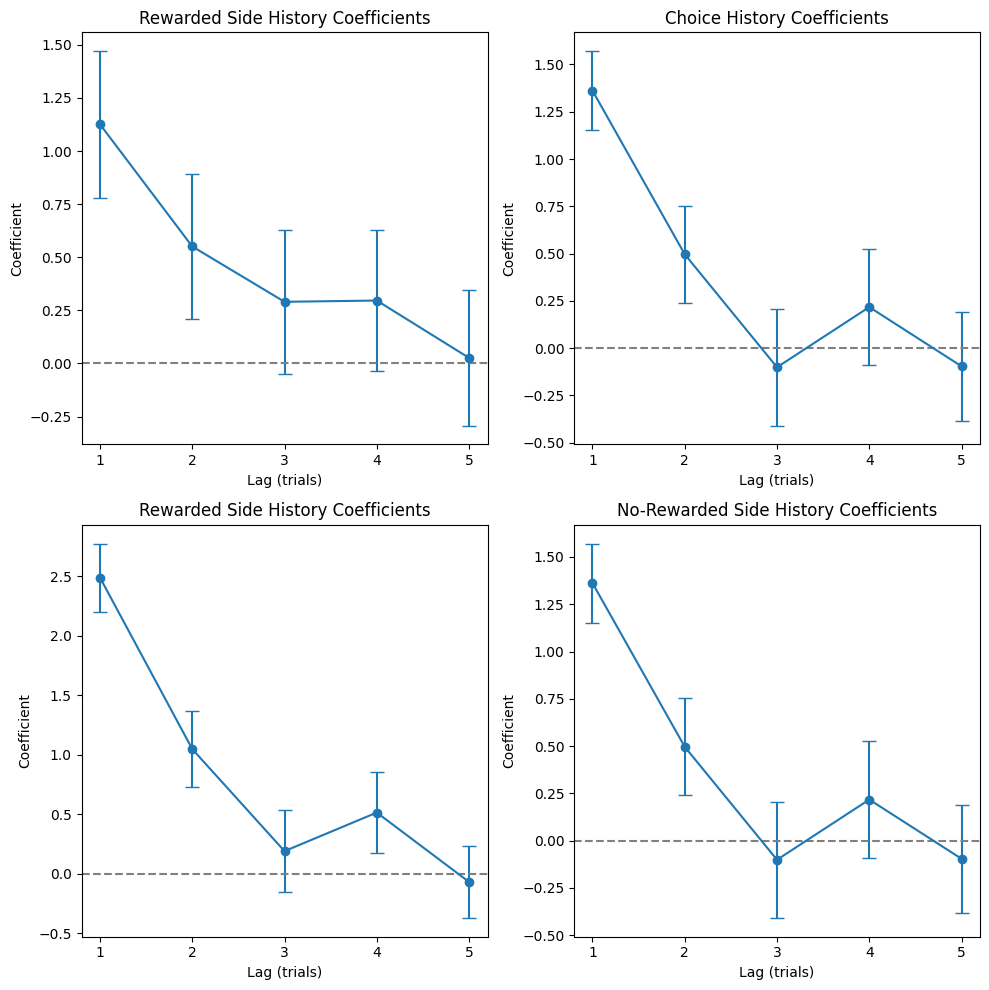

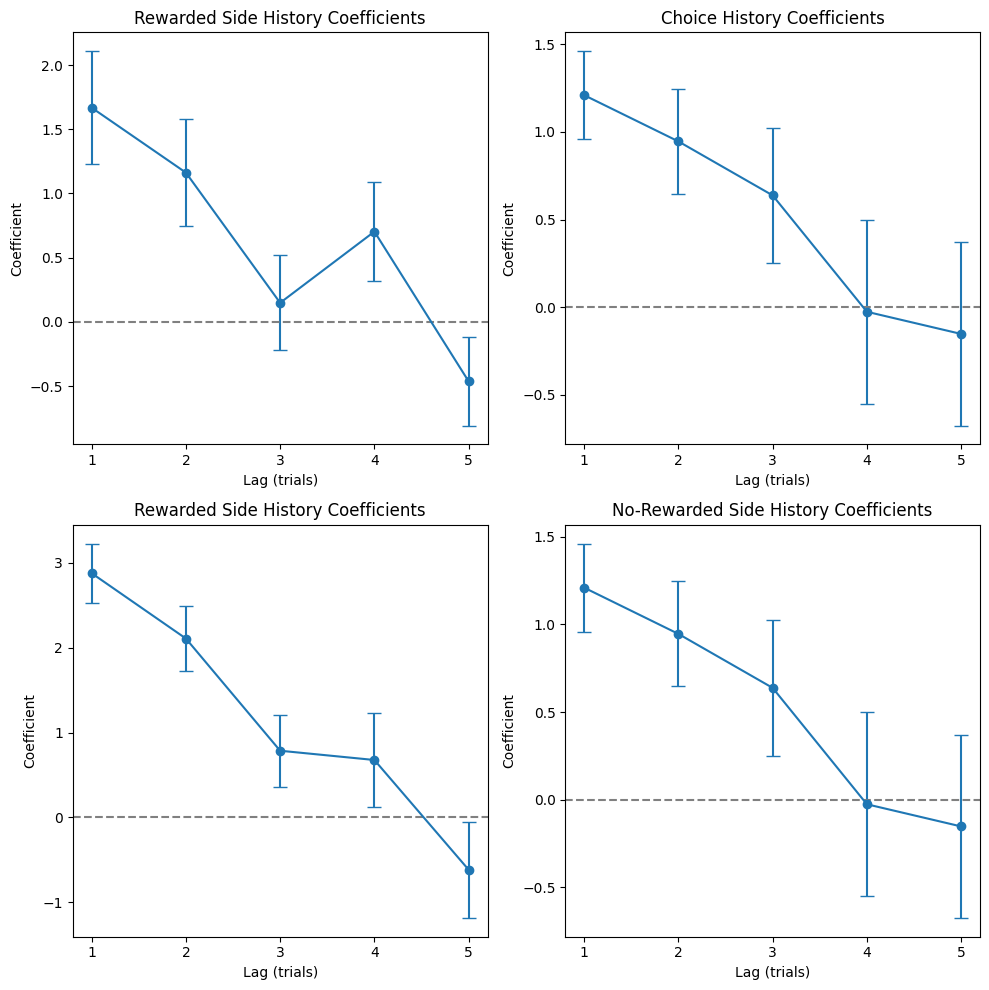

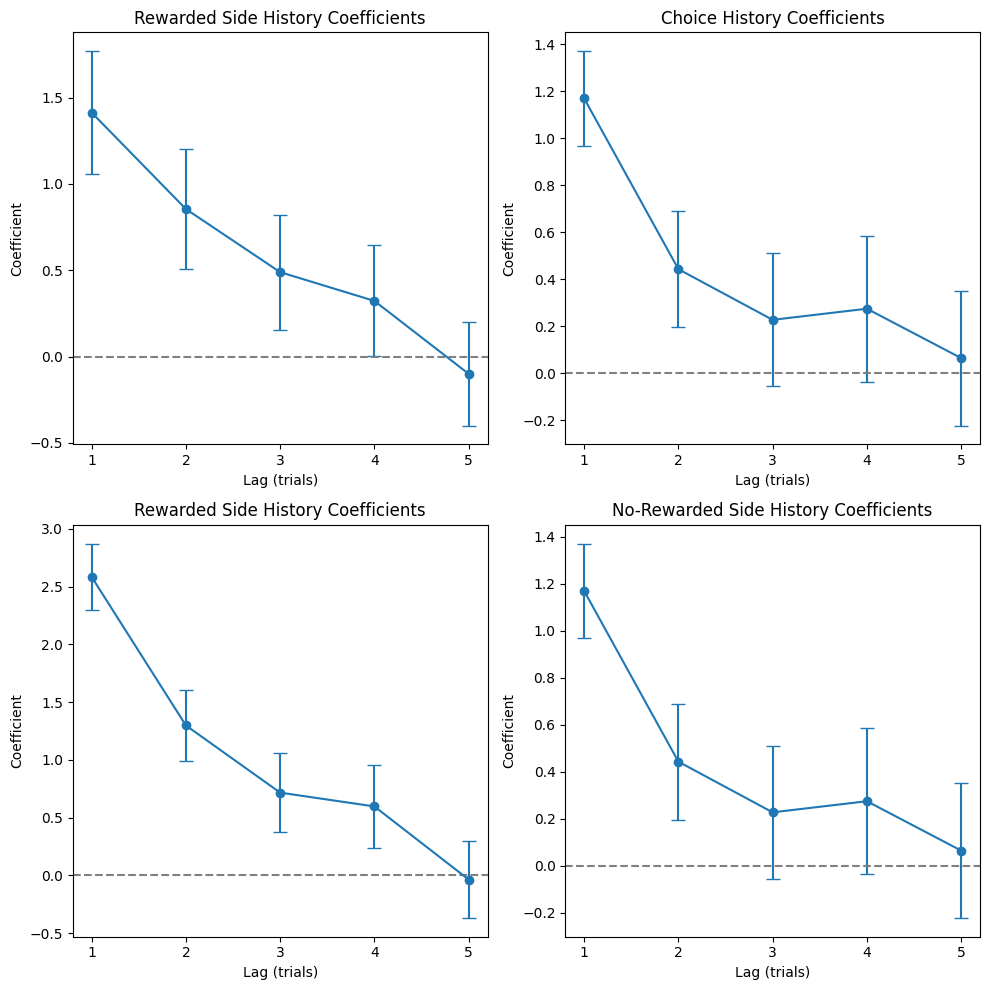

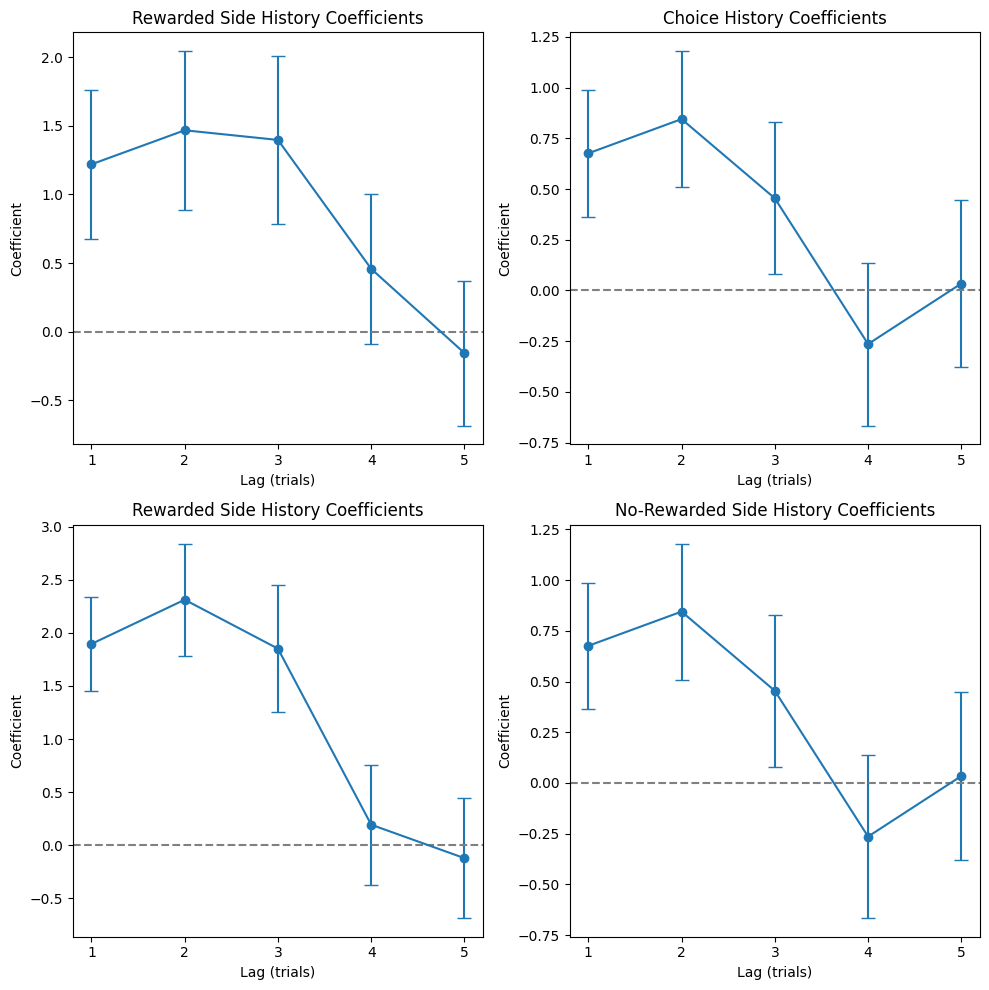

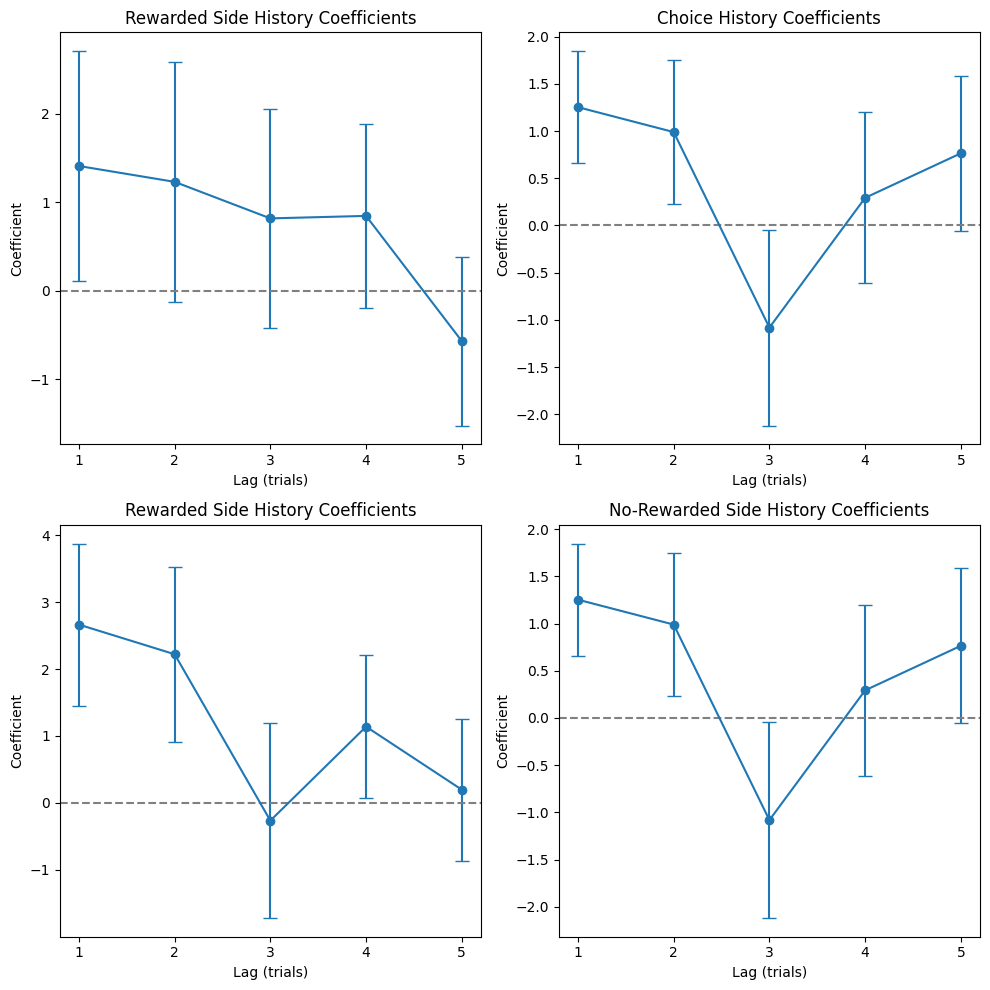

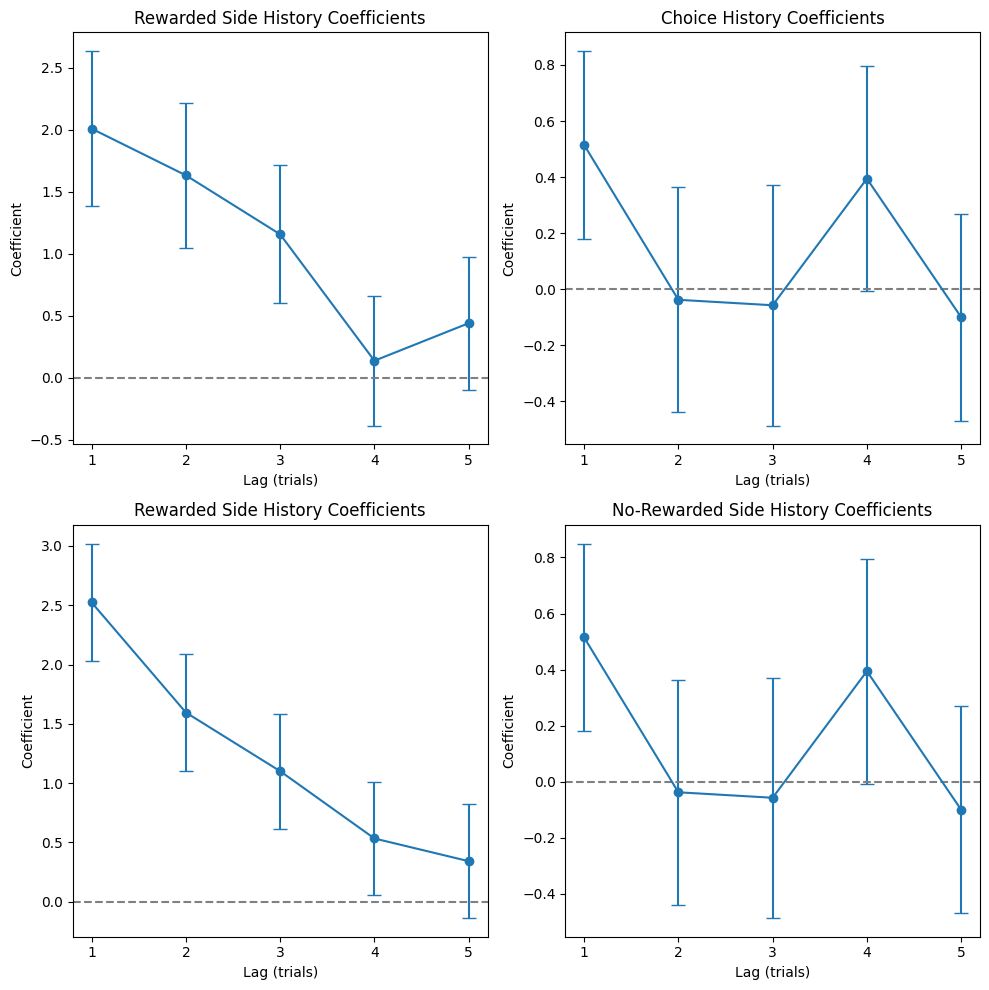

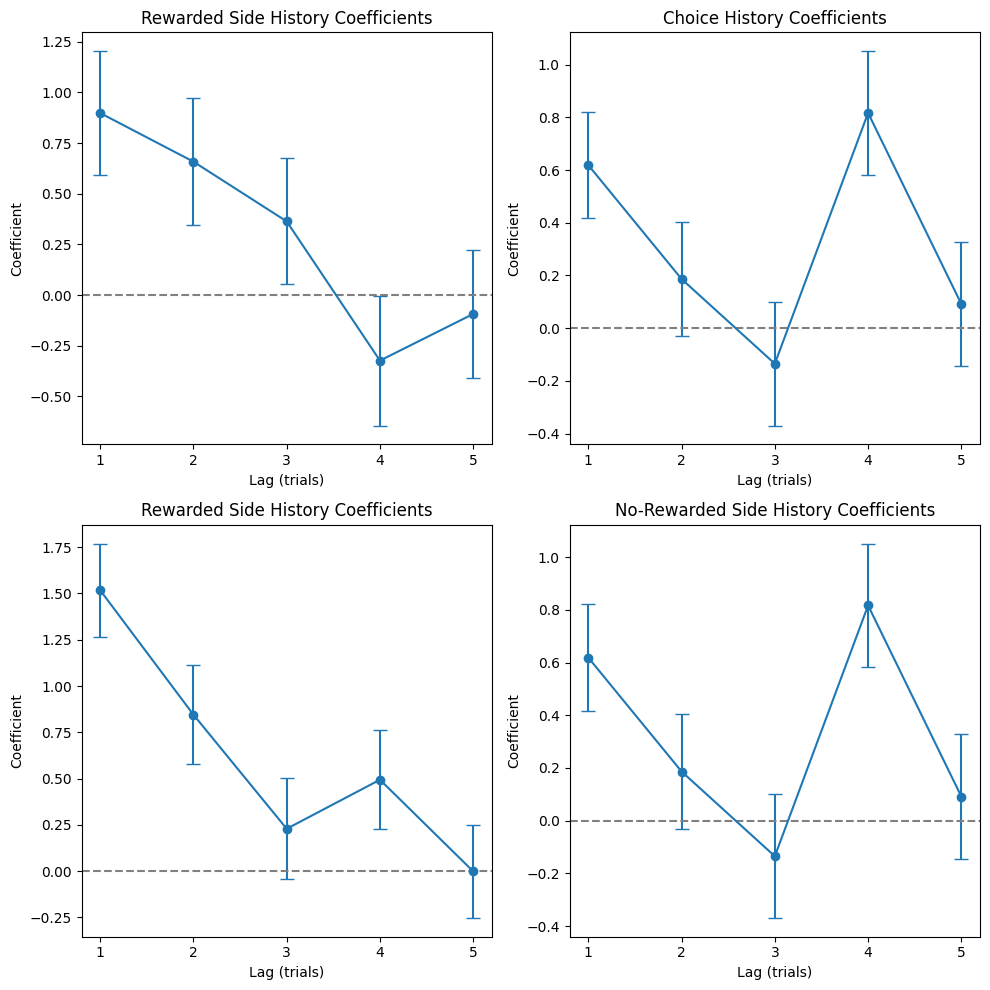

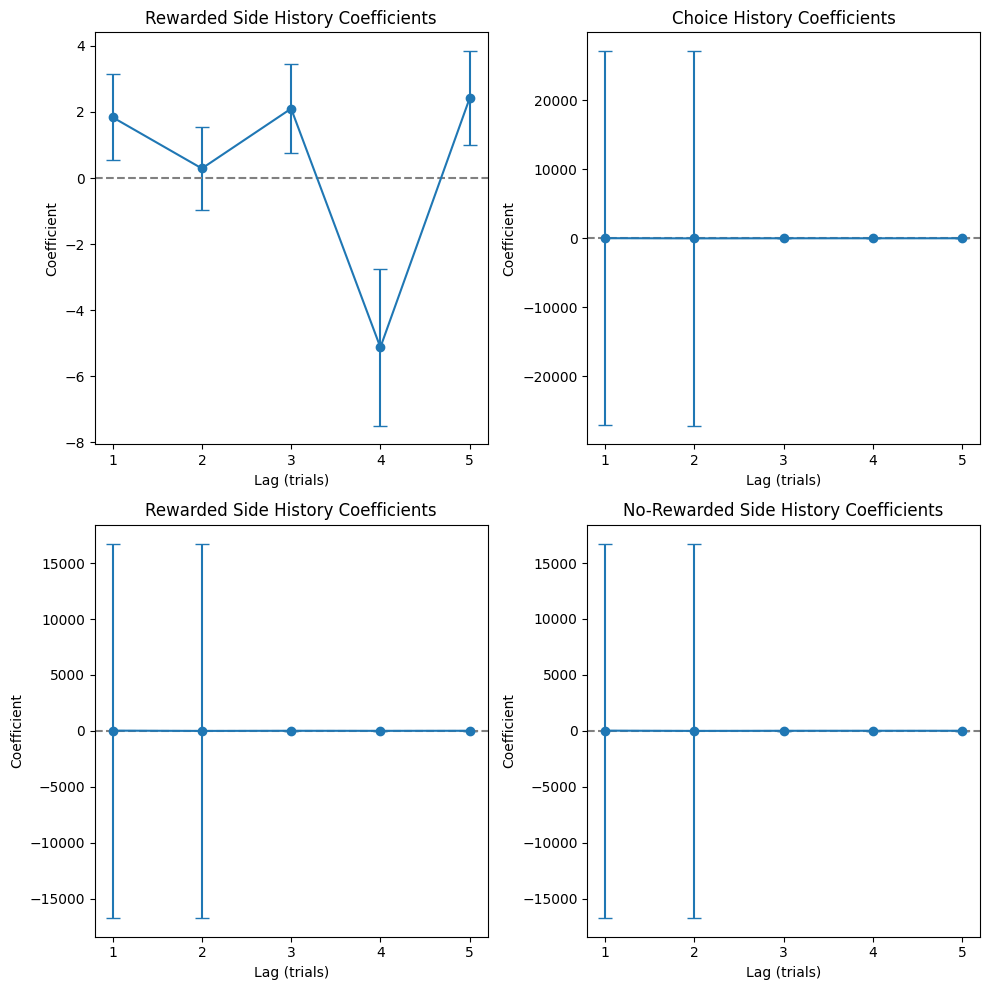

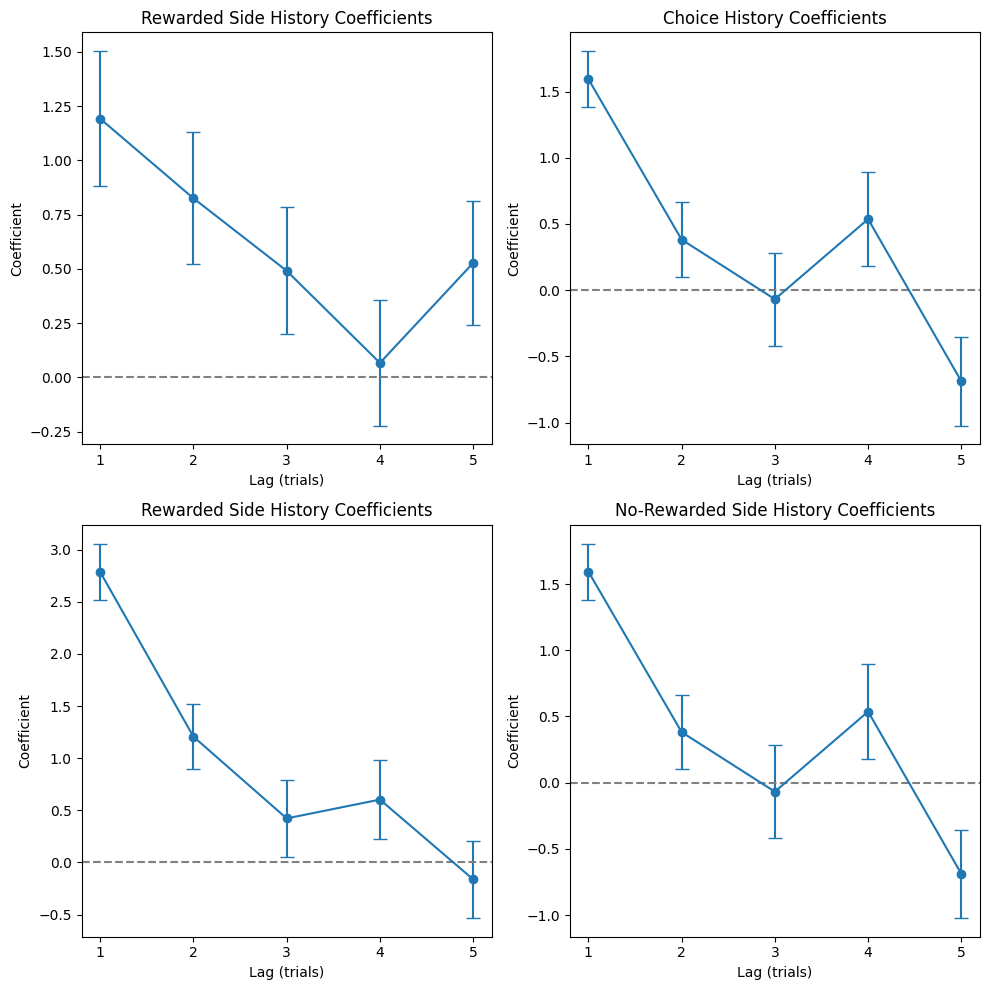

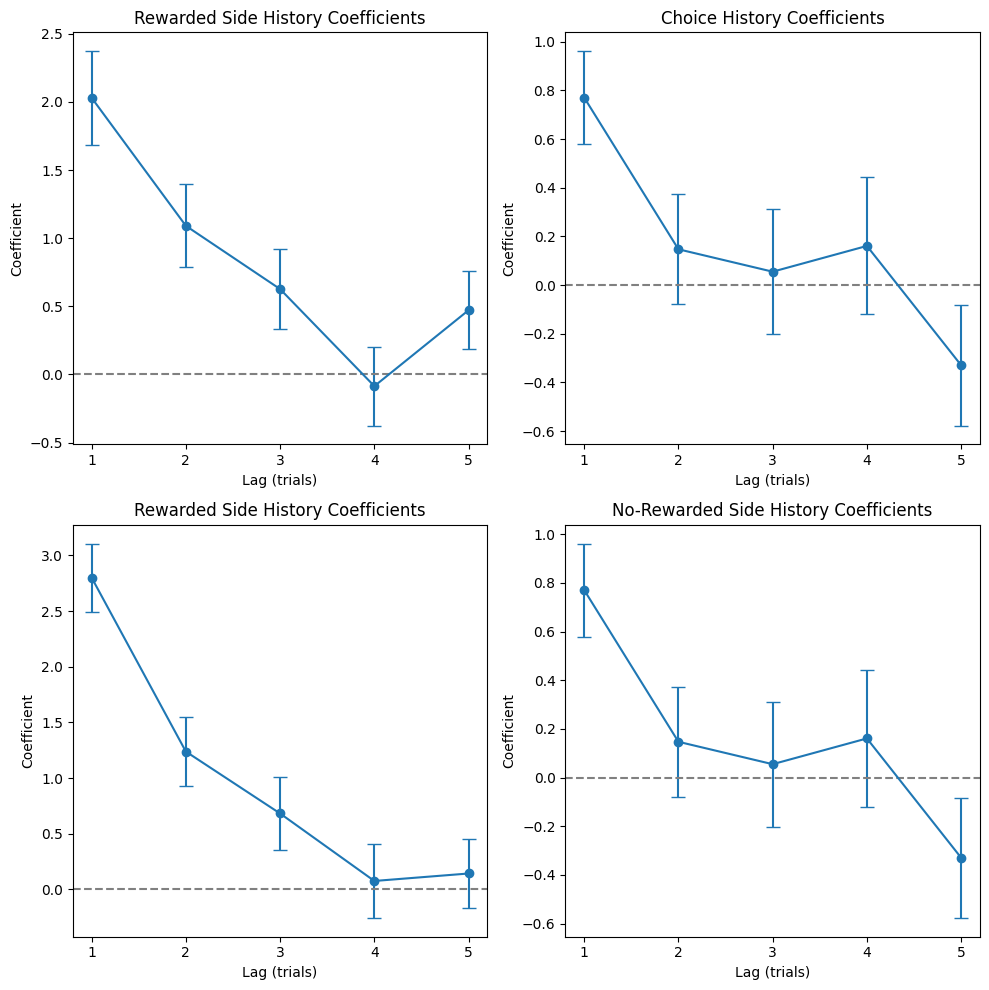

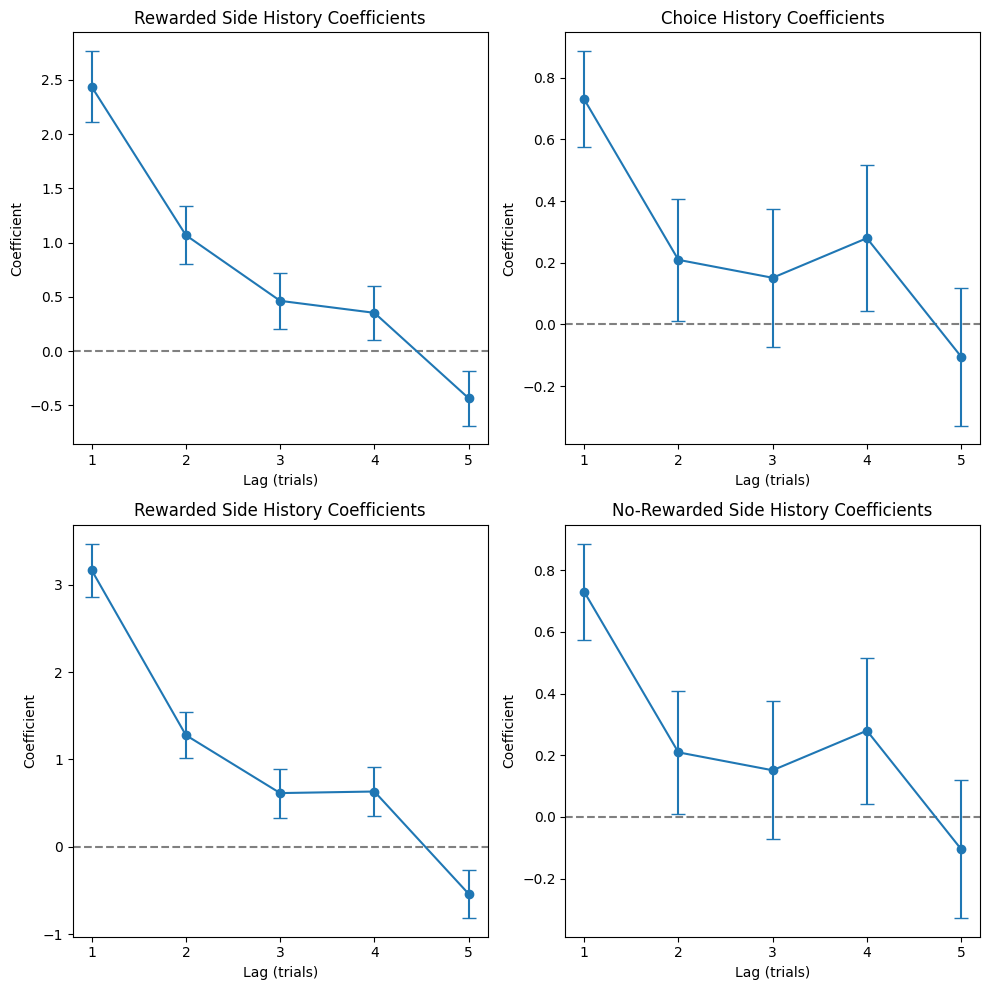

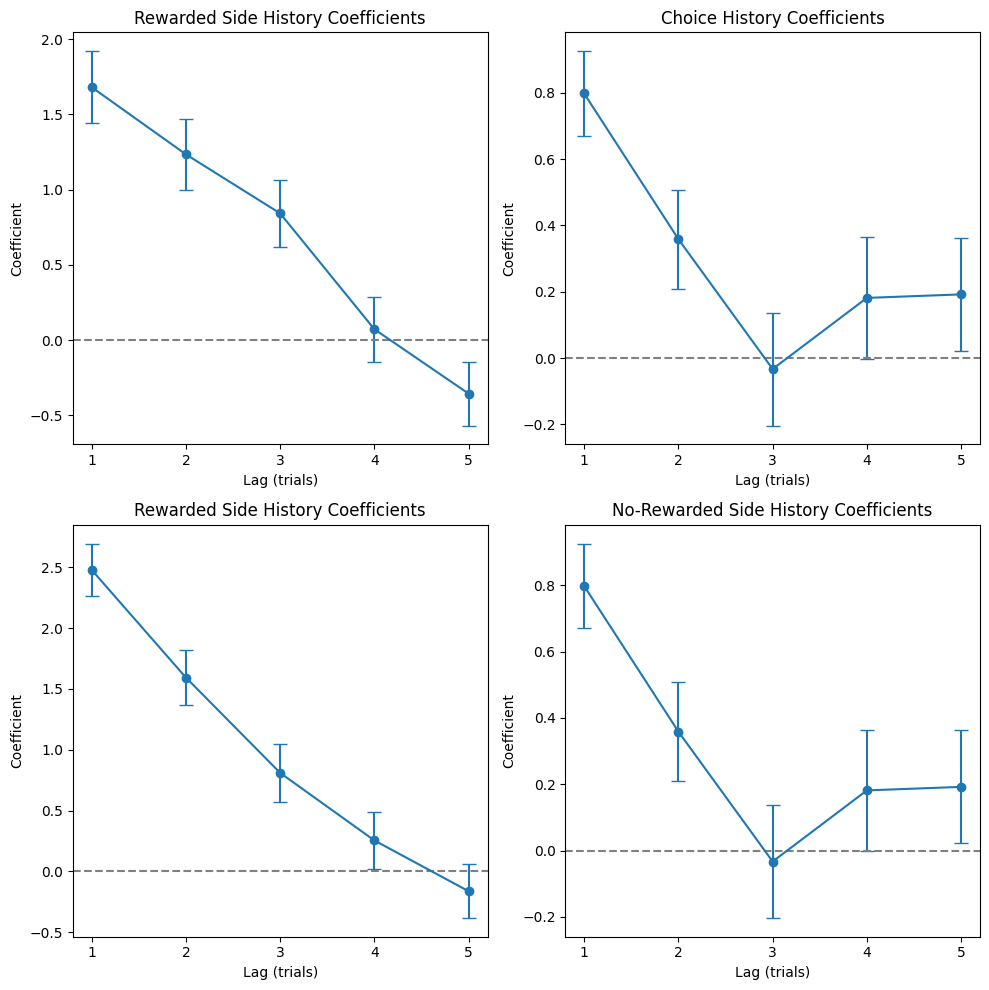

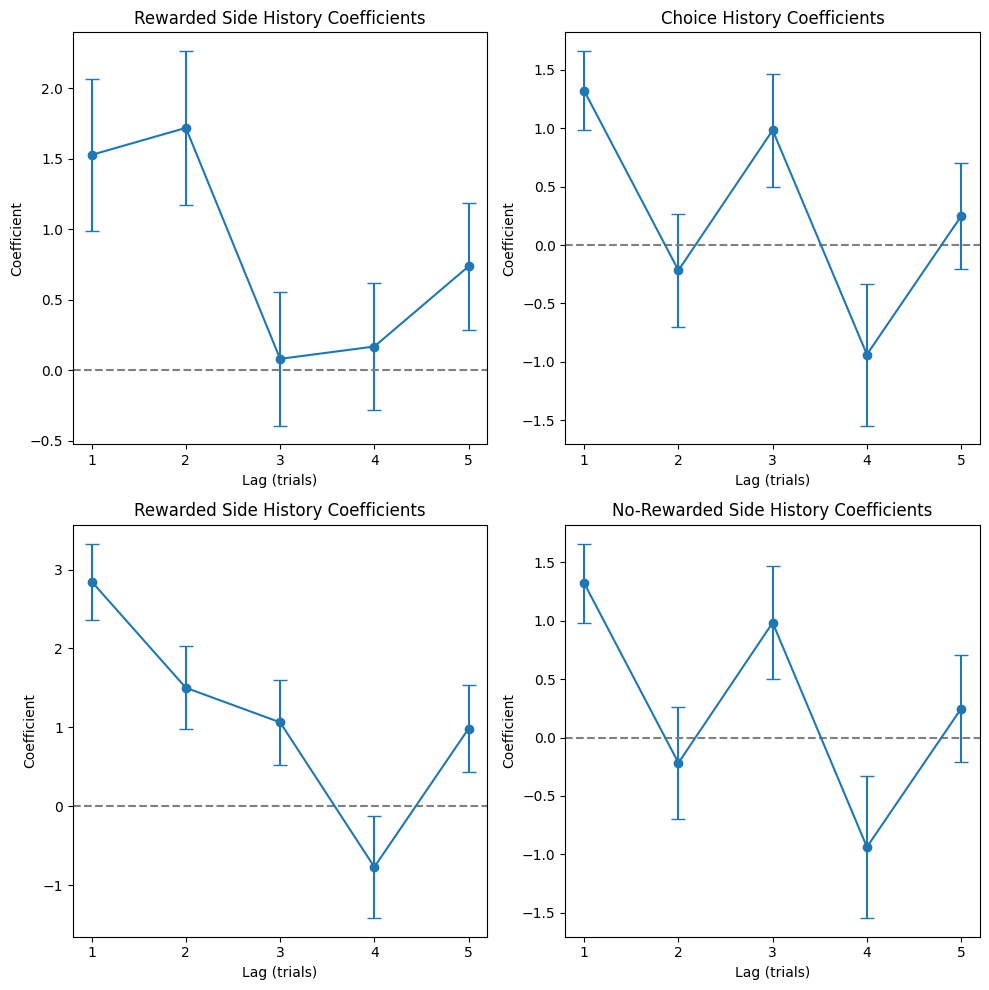

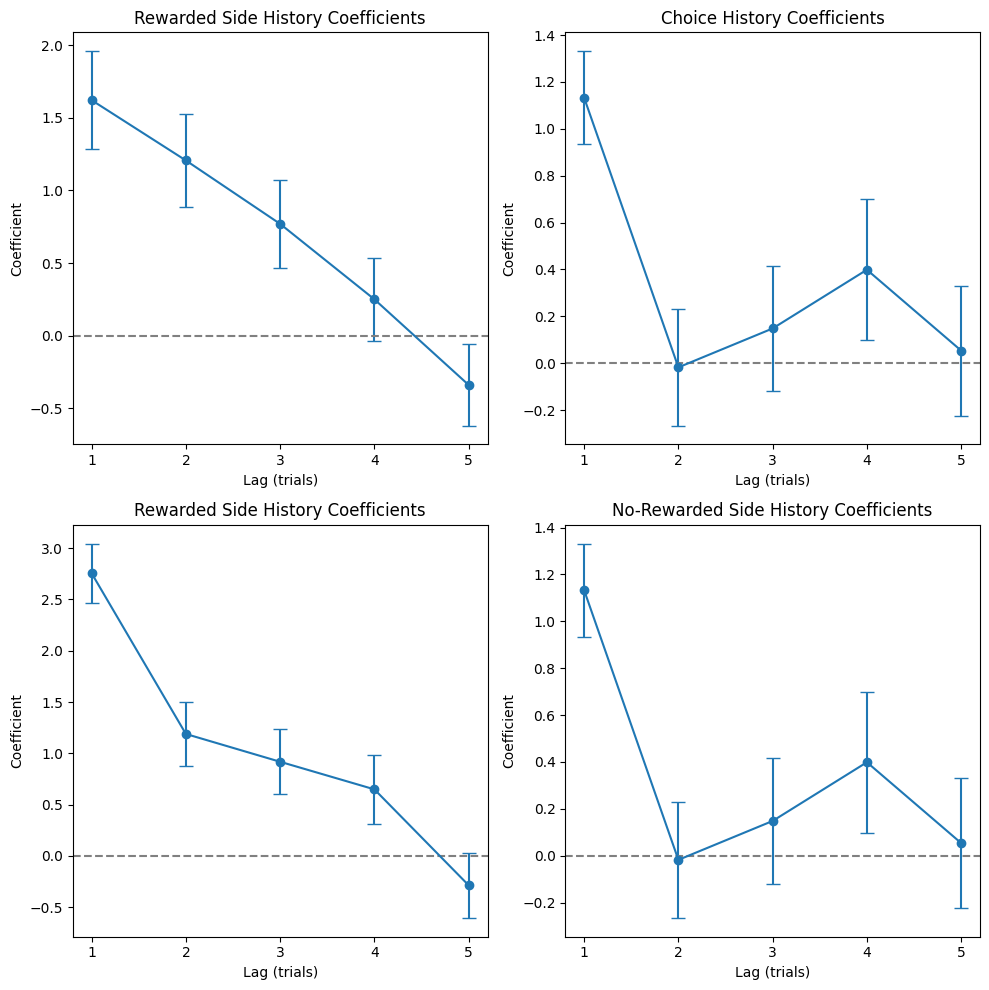

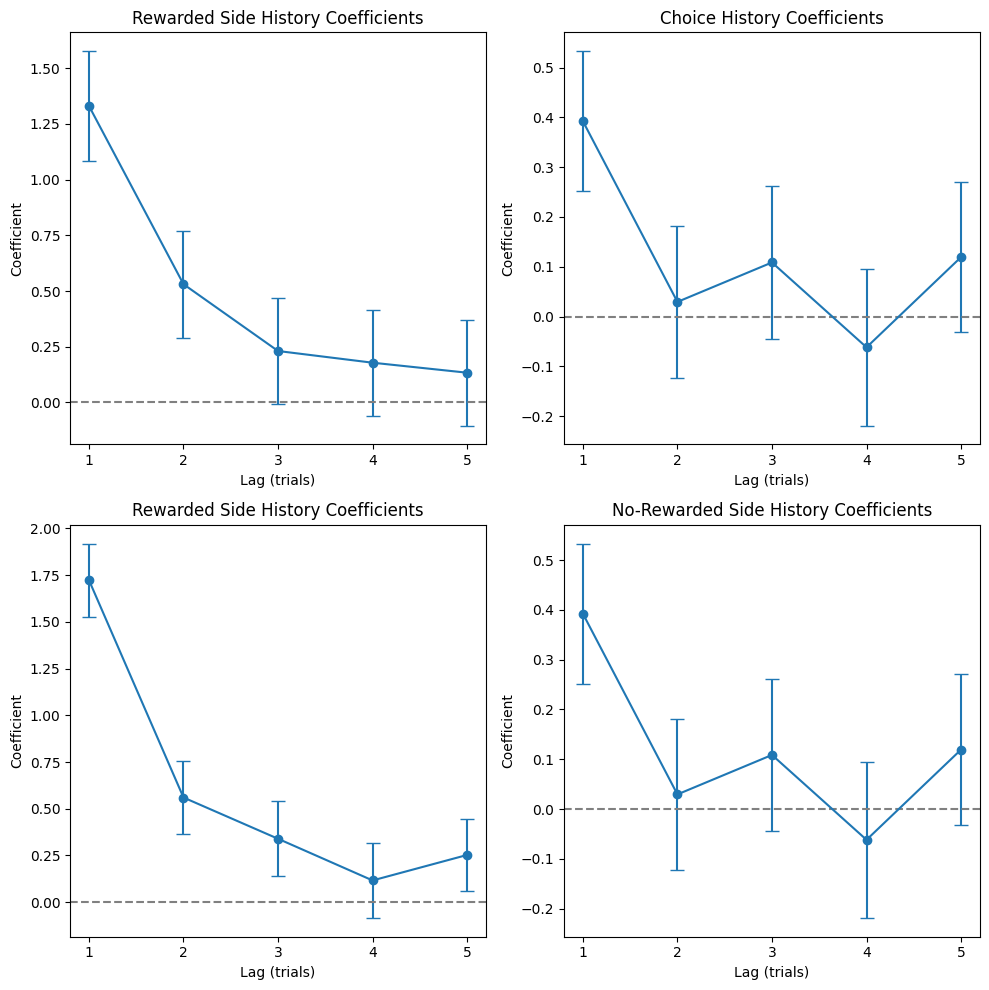

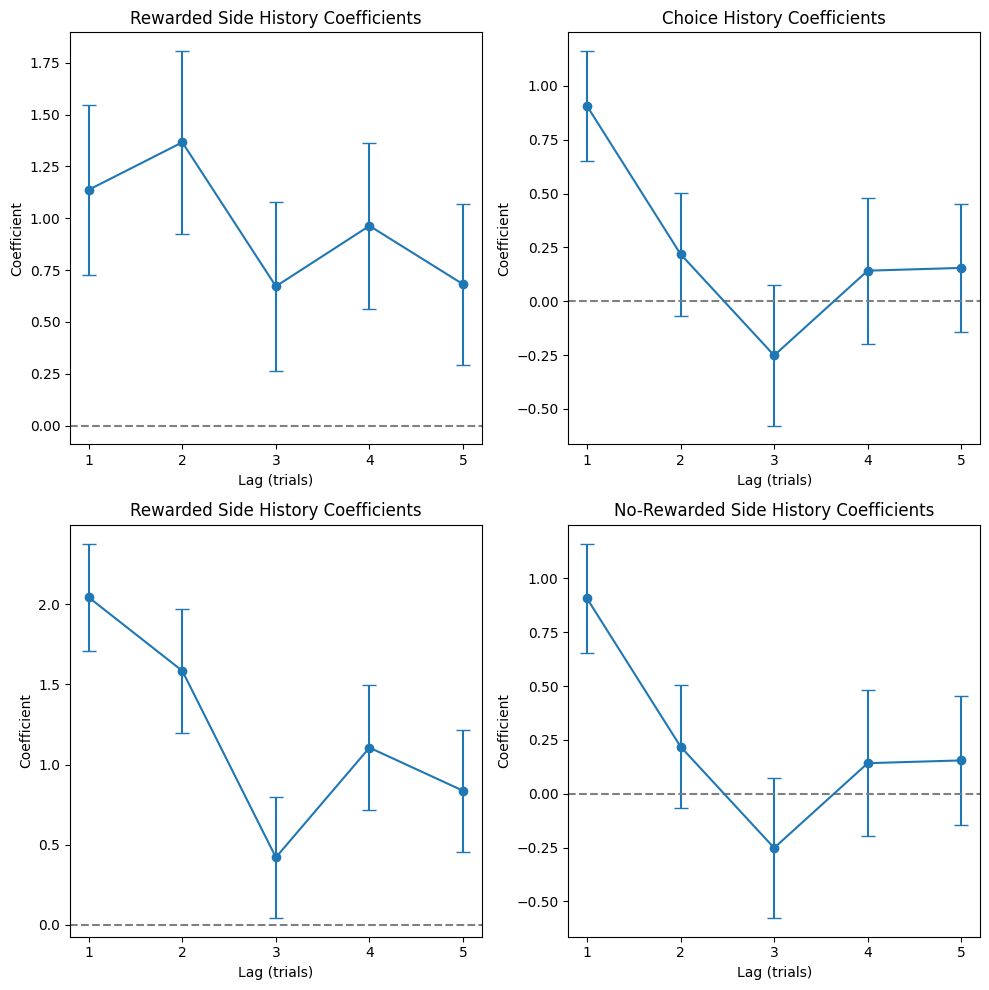

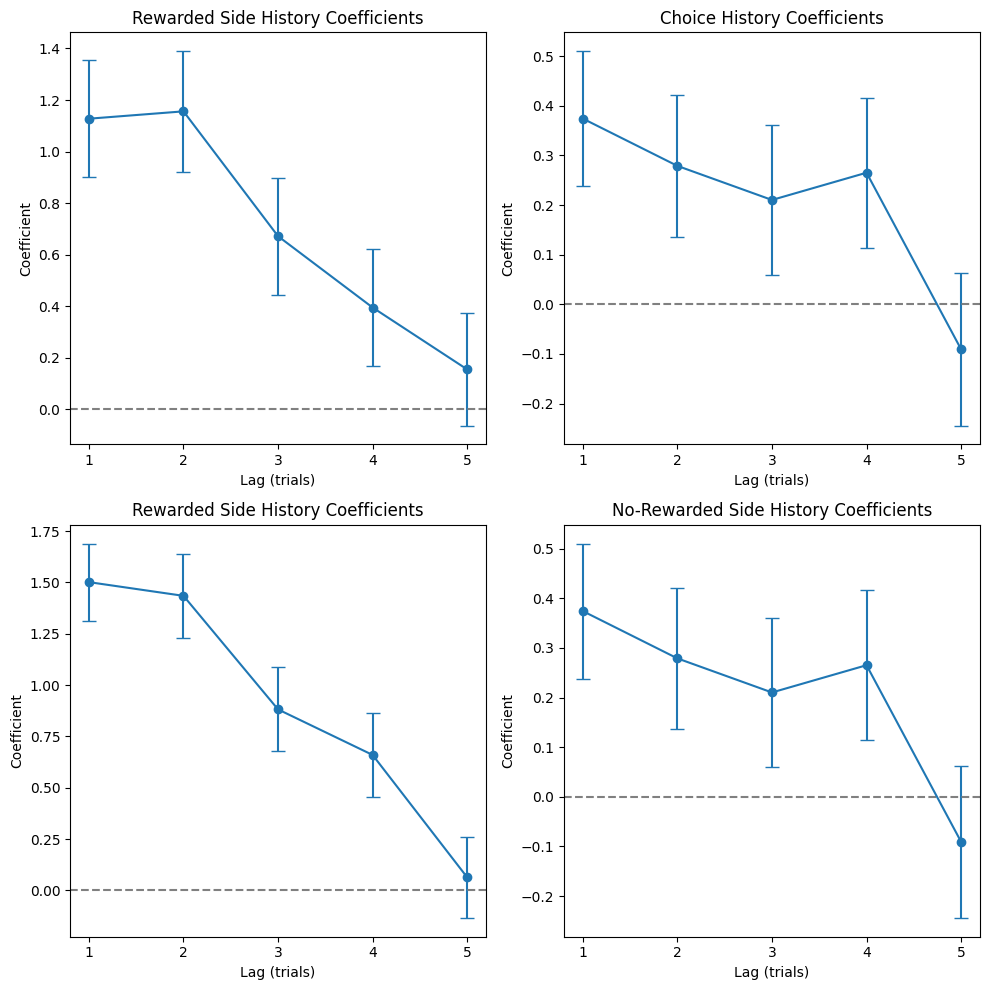

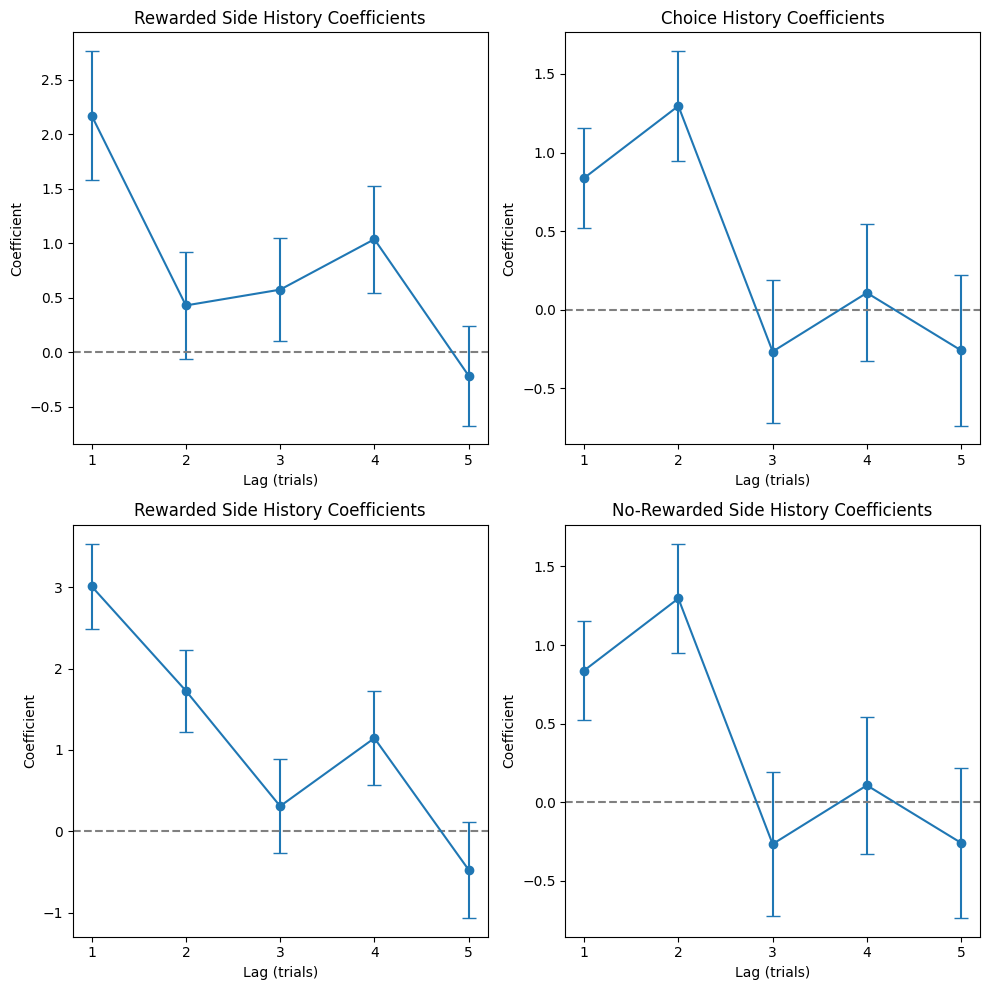

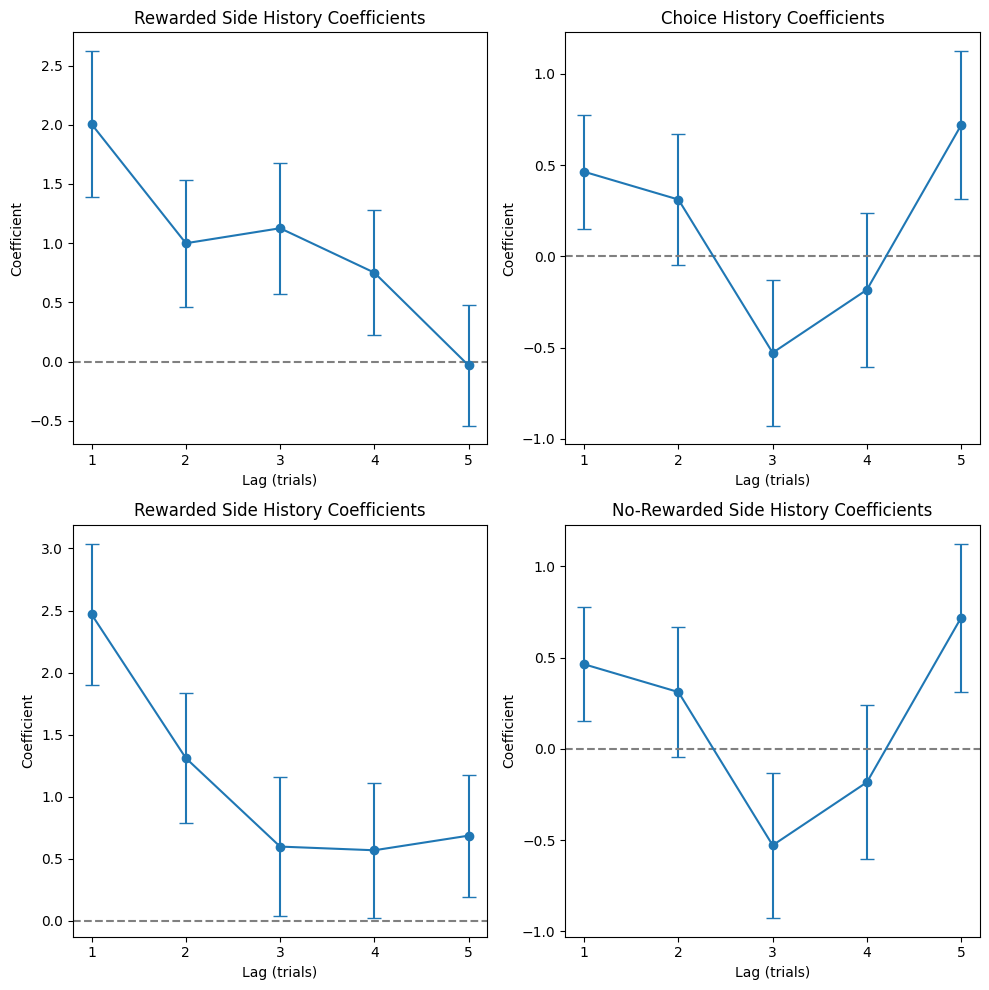

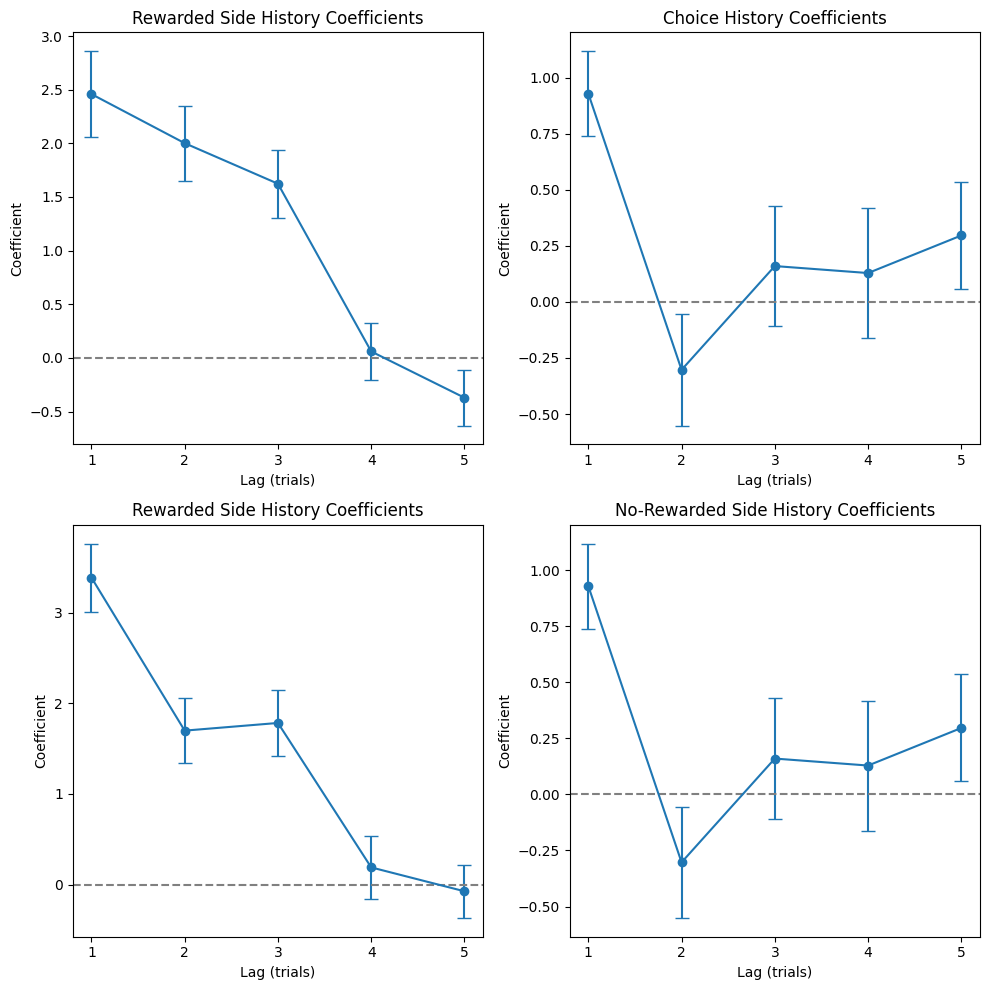

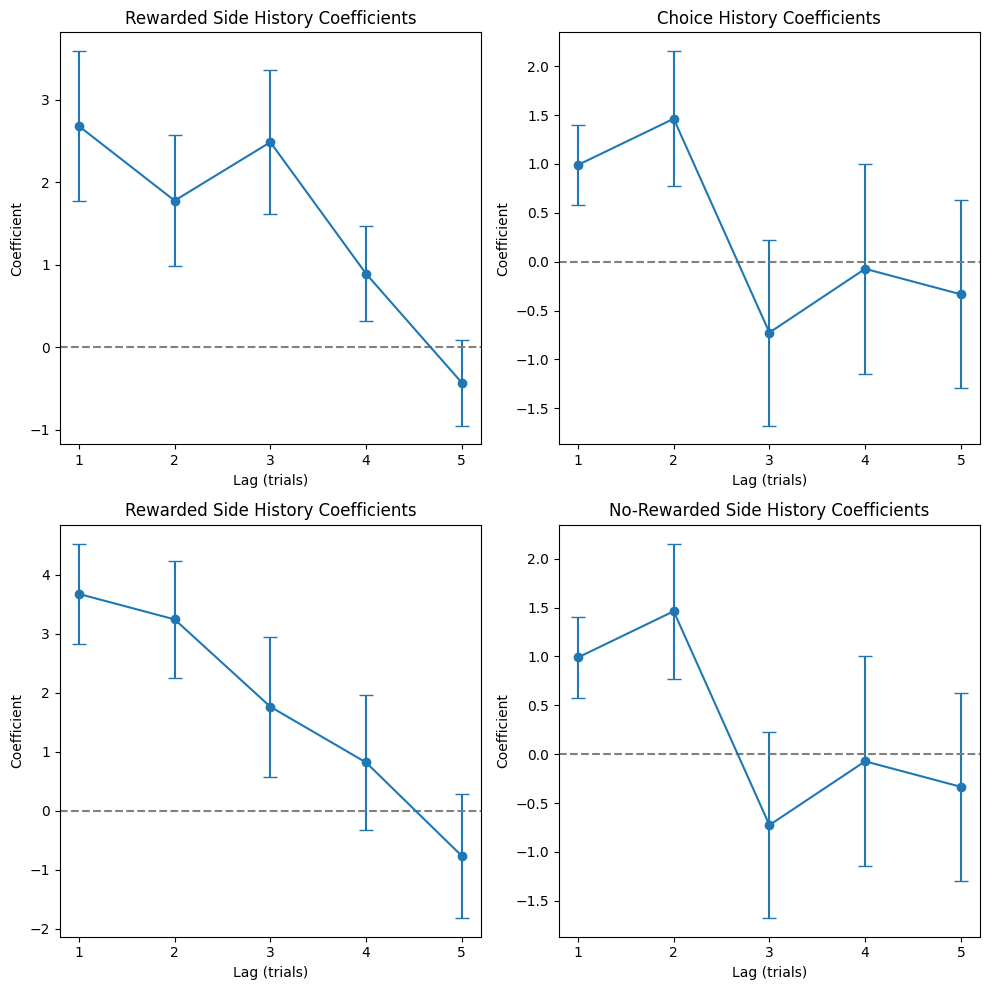

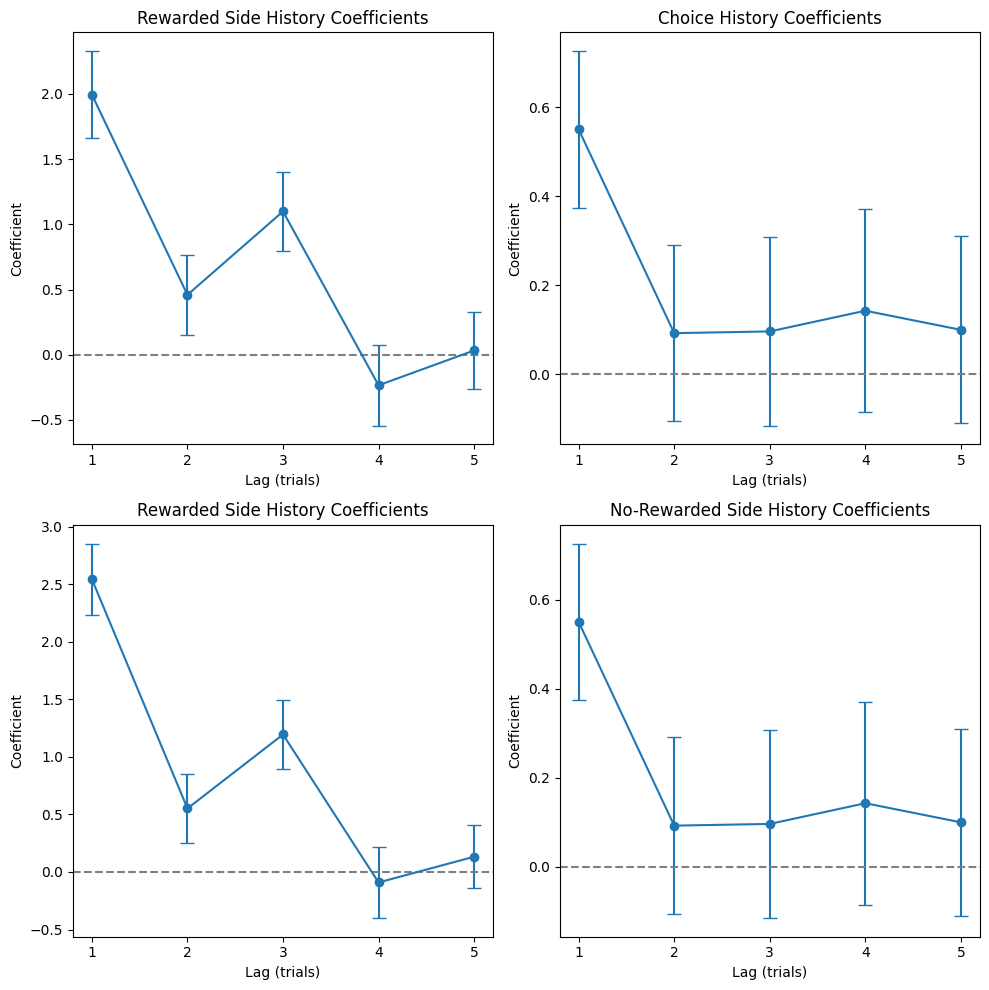

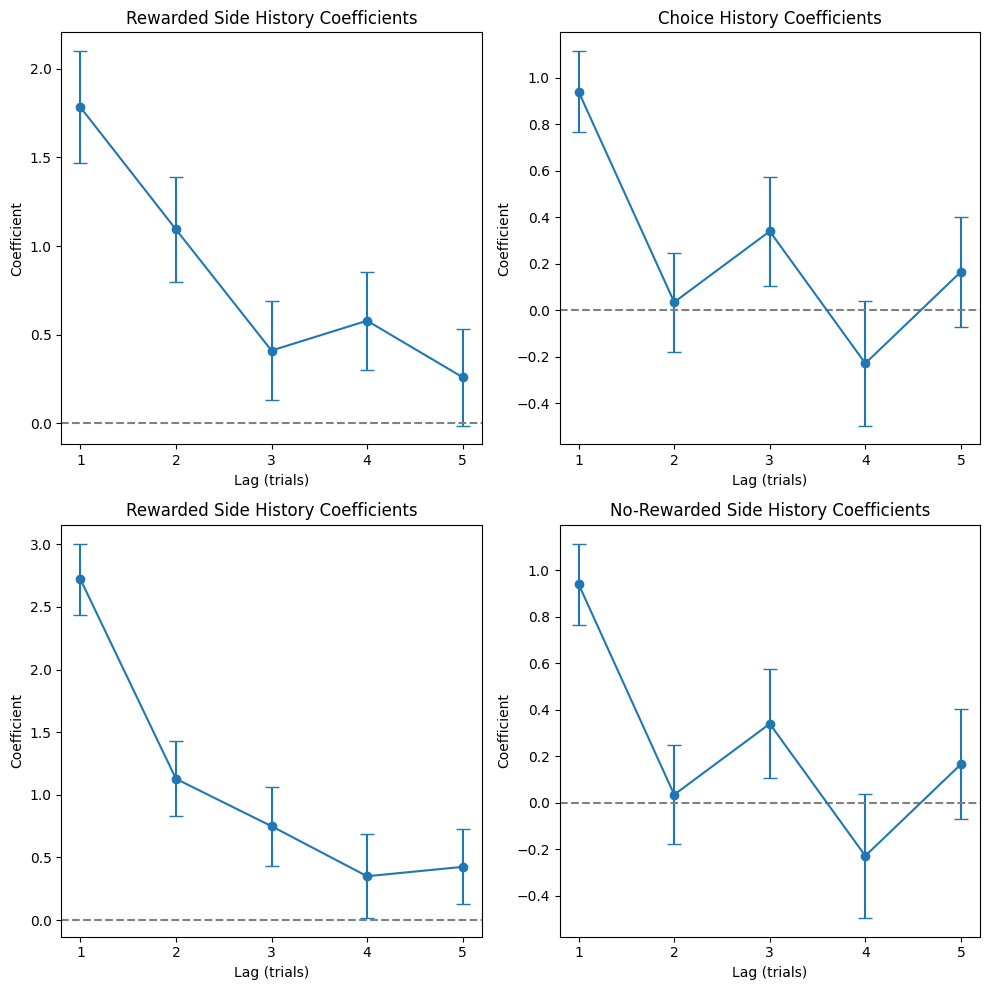

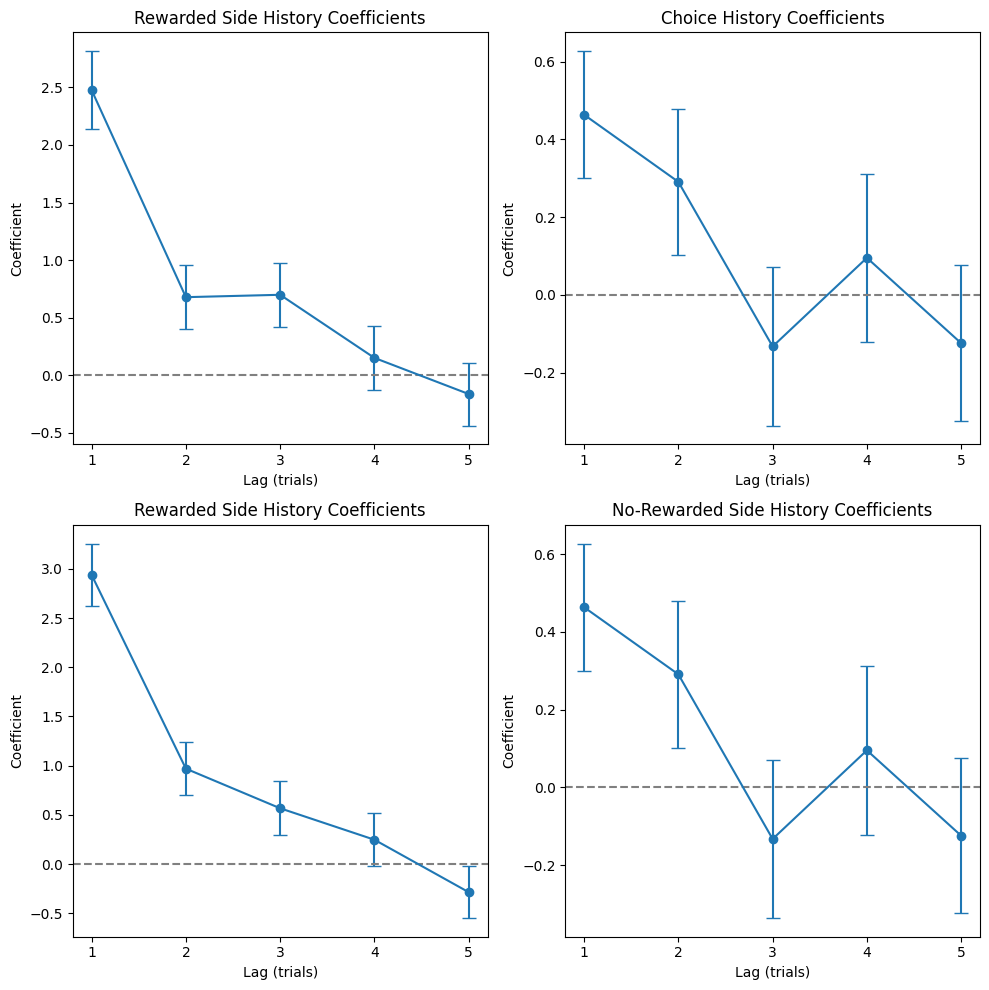

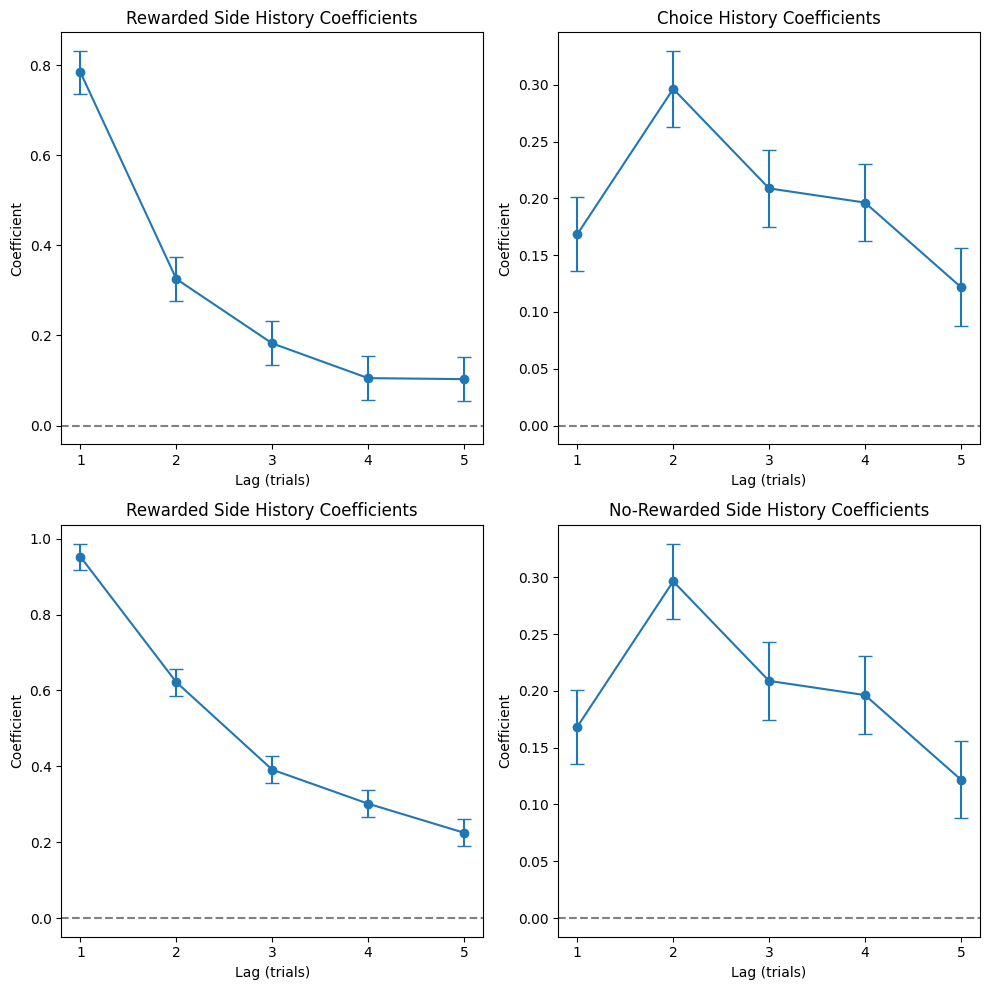

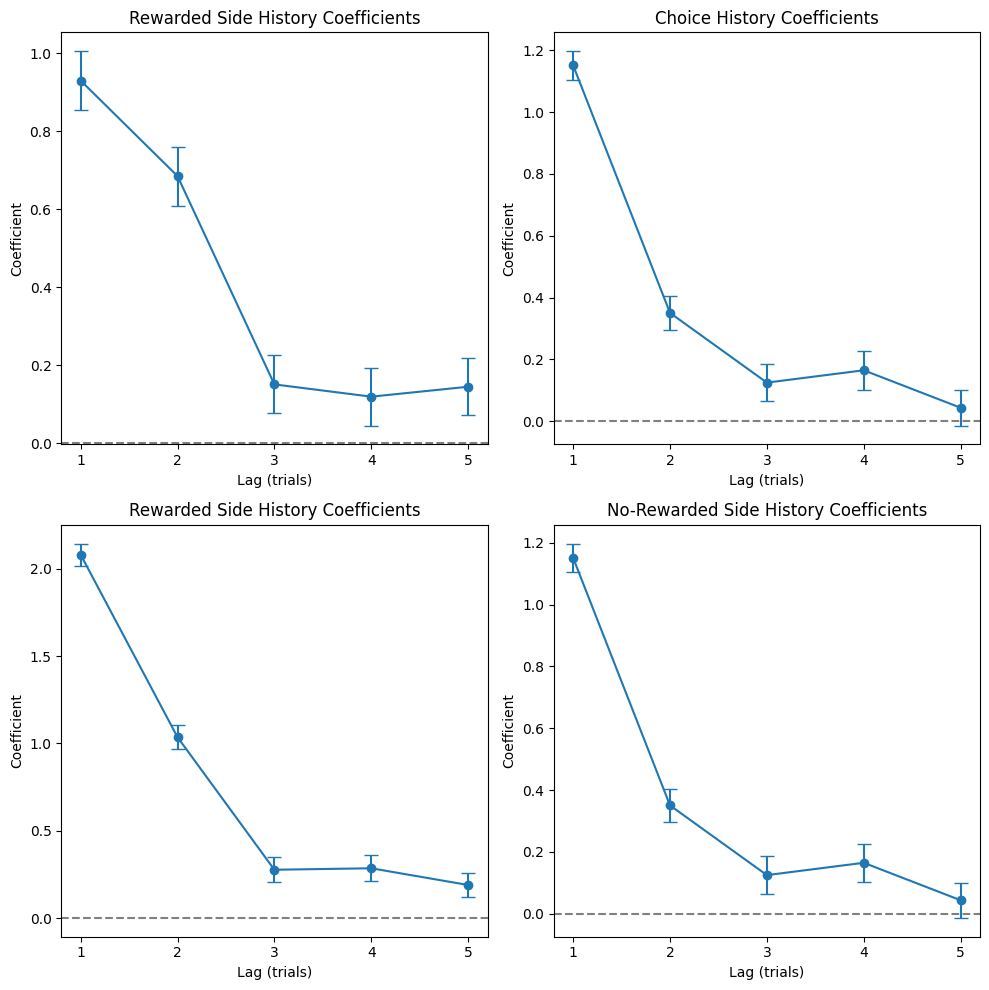

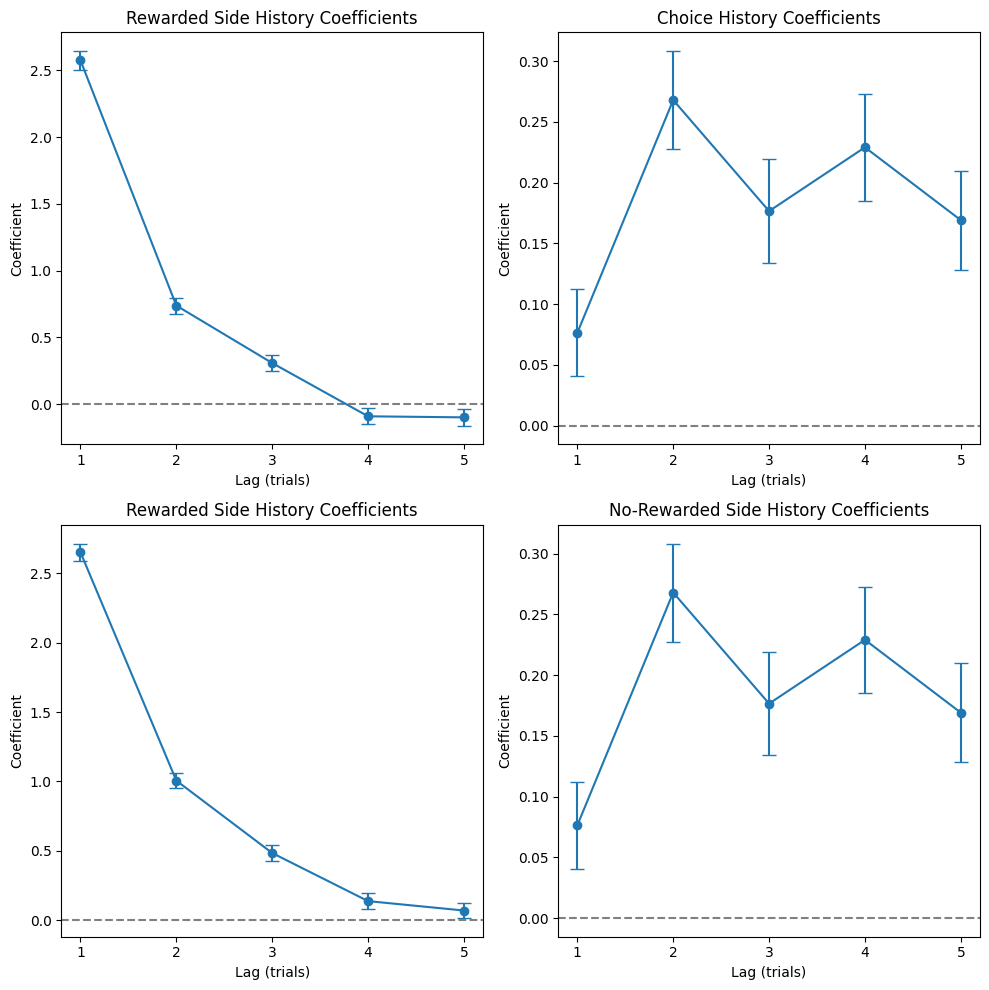

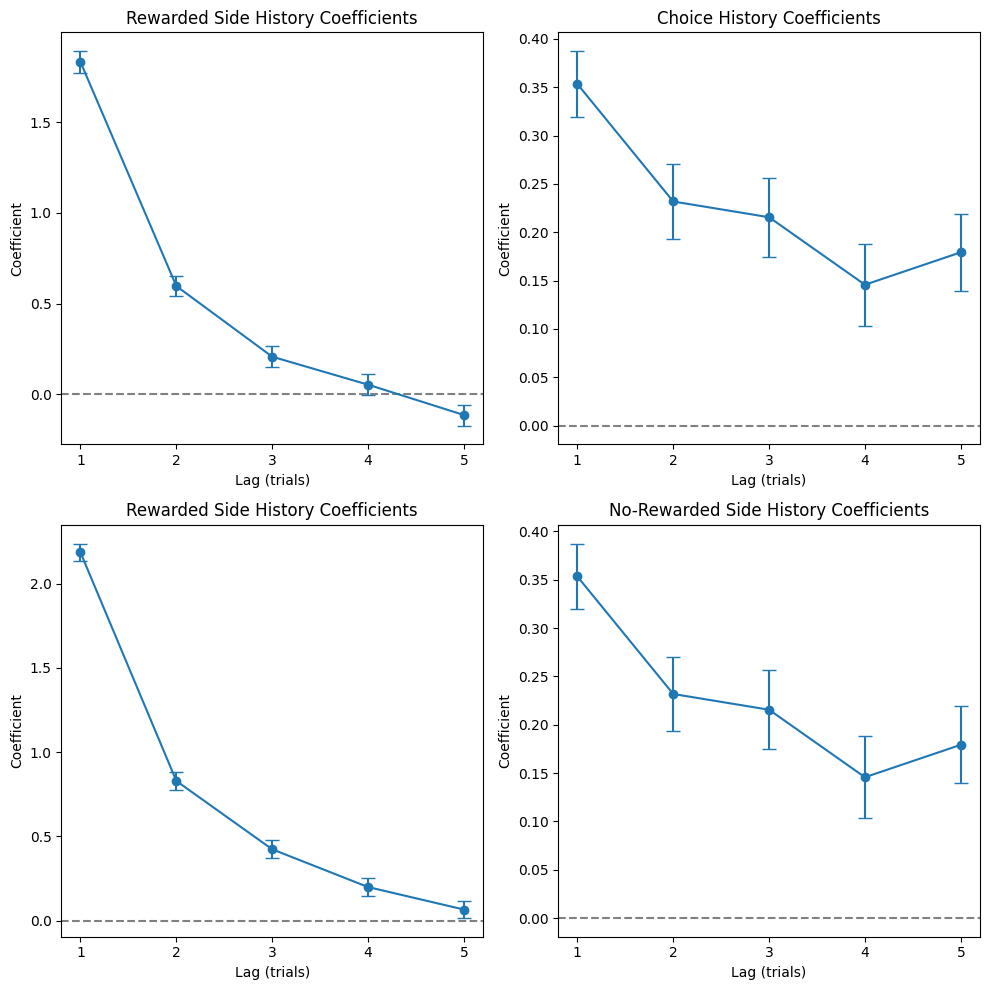

In [5]:
for ani in ani_list:
    try:
        print(f'Processing animal {ani}...')
        fit_glm_animal(ani, max_lag=5, plot=True)
    except Exception as e:
        print(f'Error processing animal {ani}: {e}')